# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')

plt.style.use(['seaborn-paper', 'seaborn-ticks']) # use seaborn-talk for presentations
%matplotlib inline

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x, TransformTension, RecoilAsTension
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


In [5]:
def clear_processed_datasets():
    !rm -dr simgnn_data/single_distr_sims/train/processed
    !rm -dr simgnn_data/single_distr_sims/val/processed

    !rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
    !rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

    !rm -dr simgnn_data/hara_movies/processed
    !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
    !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
    !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

## Training

Notes for normalisation param-s:

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies. Use same normalisation constants for all simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

---
|Dataset| Avg. edge len.|Tension/Recoil| Transforms (Normalisation)|Notes|
|:---:|---:|---:|:---|:---:|
|`single_distr_sims` | 1.08 a.u. | range=[0.00131, 4.26]; sd=0.637; median=0.305; mean=0.578; | `[Pos2Vec(scale=1.0)`, `ScaleVelocity(1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/o base tension |
|`unimodal_wbasetens_sims` | 0.906 a.u. | range=[0.407, 5.47]; sd=0.729; median=1.48; mean=1.6| `[Pos2Vec(scale=1.0)`, `ScaleVelocity(1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/ non-zero base tension |
|`HaraMovies`  | 26.32 pixels||`[Pos2Vec(scale=26.32)`, `ScaleVelocity(26.32)]`| tissue movies w/o force data|
|`HaraAblation`|$26.32\cdot\frac{0.4}{0.21}$ pixels| range=[0.0239, 2.61]; sd=0.651; median=0.673; mean=0.826 | `[Pos2Vec(scale=50.13), ScaleVelocity(50.13)]`| short movies w/ recoil data; frame rate:dataset contains vertex positions only from every 10th frame |

- Logarithm of tension: ln(Tension/Recoil {raw values})
```
Single_distr_sims:        range: [-6.63 1.45]; s.d.: 1.22 || median: -1.19; mean: -1.2;
Unimodal_wbasetens_sims : range: [-0.9  1.7]; s.d.: 0.451 || median: 0.39; mean: 0.371;
Hara ablation:            range: [-3.73 0.958]; s.d.:0.962 || median:-0.396; mean:-0.547;
```


---
- **Normalisation param-s**

In [6]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

# # Stat-s for log tension/recoil values
# t_av_log = {'sim':0.0, 'single_distr_sims': -1.2, 'unimodal_wbasetens_sims': 0.37, 'abln': -0.55}
# t_sd_log = {'sim':1.0, 'single_distr_sims': 1.2, 'unimodal_wbasetens_sims':0.45 , 'abln': 0.96}

- For log-transform of tension use : e.g. `TransformTension(torch.log), ScaleTension(t_sd_log['sim'], shift=t_av_log['sim'])` 

### Datasets

In [85]:
# clear_processed_datasets()

In [19]:
window_size = 5
sma_lag_time = 4

print(f'> Set features window size (#past velocities) to {window_size}')

> Set features window size (#past velocities) to 5


In [34]:
# Normalisation
# for simulated data (simul params ~ normal distr-s): l0_sim=1.0, l0_HaraMovie: l0=26.32
Tnrm = {} # dict of transforms

# Default for all simulations:
Tnrm['sim'] = T.Compose([Pos2Vec(scale=l_0['sim']) , ScaleVelocity(scale=l_0['sim']),
                         ScaleTension(t_sd['sim'], shift=t_av['sim']),
#                          ScaleTension(t_av['sim']),
                         Reshape_x((-1,window_size*2)) ] )

# w/o base contractility:
Tnrm['single_distr_sims'] = T.Compose([Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']),
                                       ScaleTension(t_sd['single_distr_sims'], shift=t_av['single_distr_sims']),
#                                        ScaleTension(t_av['single_distr_sims']),
                                       Reshape_x((-1,window_size*2)) ] )

# w/ base contractility:
Tnrm['unimodal_wbasetens_sims'] = T.Compose([Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']),
                                             ScaleTension(t_sd['unimodal_wbasetens_sims'], shift=t_av['unimodal_wbasetens_sims']),
#                                              ScaleTension(t_av['unimodal_wbasetens_sims']),
                                             Reshape_x((-1,window_size*2)) ] )

# Hara ablation norm
Tnrm['abln'] = T.Compose([Pos2Vec(scale=l_0['abln']), ScaleVelocity(l_0['abln']), RecoilAsTension(),
                          ScaleTension(t_sd['abln'], shift=t_av['abln']),
#                           ScaleTension(t_av['abln']),
                          Reshape_x((-1,window_size*2))]) 

# Hara movie dataset norm
Tnrm['hara'] = T.Compose([Pos2Vec(scale=l_0['hara']) , ScaleVelocity(l_0['hara']), Reshape_x((-1,window_size*2))]) 

In [77]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=sma_lag_time)
# hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=sma_lag_time)

# Hara movie datasets
seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnrm['hara'],smoothing=True, sma_lag_time=sma_lag_time)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnrm['hara'],smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnrm['hara'],smoothing=True, sma_lag_time=4)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
# sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size,
#                       transform=Tnrm['single_distr_sims'])
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val[:len(sim1_val)//2]+sim1_val[len(sim1_val)//2:-1],
                 'val2': sim2_val[:len(sim2_val)//2]+sim1_val[len(sim2_val)//2:-1],
                 'H1' : seg001,
                 'A': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'H1': r'$\mathcal{H}_1$',
                'A': r'$v_{recoil}$'}

rm: cannot remove 'simgnn_data/single_distr_sims/train/processed': No such file or directory
rm: cannot remove 'simgnn_data/single_distr_sims/val/processed': No such file or directory
rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/train/processed': No such file or directory
rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/val/processed': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies/processed': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/': No such file or directory
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [78]:
# k='val2'
# print('{}\n{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Persistence Loss

In [79]:
# print('Persistence:')
# for k in datasets_dict:
#     if k=='abln':print('Ignoring ablation data velocity');continue
#     print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

In [80]:
len(datasets_dict['train'])

280

#### Single MP Step Tension Model

In [81]:
from simgnn.train import train_model, write_log, load_log, plot_losses
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction

In [89]:
from simgnn.models import SingleMP_Tension

In [90]:
torch.manual_seed(0)

dropout_p = 0.1
num_epochs = 100
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')

num_hidden = 10
msg_dim = 128  # message MLP latent dim-s
upd_dim = 128  # update MLP latent dim-s

# Update func (MLP) depth
upd_h_layers = max([0, num_hidden//2])# Update MLP hidden_layers
update_hidden_dims=[upd_dim for k in range(upd_h_layers-1)]+[16]
# Message func (MLP) depth
msg_h_layers = max([0, num_hidden - upd_h_layers])# Message MLP hidden_layers
message_hidden_dims = [msg_dim for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model

net = SingleMP_Tension(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                       message_out_features=msg_dim, message_hidden_dims=message_hidden_dims,
                       tension_hidden_dims=update_hidden_dims,
                       aggr='mean', update_hidden_dims=update_hidden_dims, dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
           'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
#            'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
#            'abln':   DataLoader(datasets_dict['abln'], batch_size=bs),
#            'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 
                  'val':[True, False],
#                   'val2':[True,False] ,
#                   'abln':[True,False] ,
#                   'hara' : [False, False]
                 }# [tension, pressure]

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_h{num_hidden}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'

In [91]:
print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

18042022_051501_SingleMP_Tension_h10_dp0.1bs2w5
---
Training param-s: #epochs=100, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/99: train_loss_tot=  0.7526; train_loss_y=0.002604; train_loss_T=    0.75; |val_loss_tot=   0.539; |4s
Epoch 1/99: train_loss_tot=  0.5289; train_loss_y=0.001236; train_loss_T=  0.5277; |val_loss_tot=  0.4599; |7s
Epoch 2/99: train_loss_tot=  0.4983; train_loss_y=0.0007707; train_loss_T=  0.4976; |val_loss_tot=  0.4602; |11s
Epoch 3/99: train_loss_tot=   0.487; train_loss_y=0.0006536; train_loss_T=  0.4863; |val_loss_tot=  0.4554; |14s
Epoch 4/99: train_loss_tot=  0.4802; train_loss_y=0.0005902; train_loss_T=  0.4796; |val_loss_tot=  0.4606; |17s
Epoch 5/99: train_loss_tot=  0.4777; train_loss_y=0.0005355; train_loss_T=  0.4772; |val_loss_tot=  0.4578; |21s
Epoch 6/99: train_loss_tot=  0.4731; train_loss_y=0.000503; train_loss_T=  0.4726; |val_loss_tot=  0.4607; |24s
Epoch 7/99: train_loss_tot=  0.4699; train_loss_y=0.0

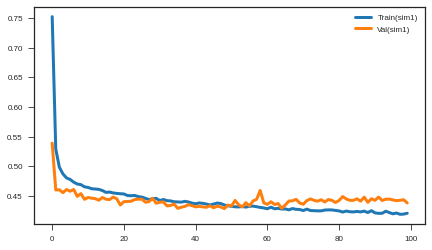

In [93]:
# plot losses
plot_losses(train_log, loaders, dataset_legend, figsize=[7,4]); plt.show()

- train_loss_tot =0.41143125240752265;
- train_loss_y =0.00023079671242717296;
- train_loss_T =0.4112004556950955;
- train_loss_P =0.0;
- val_loss_tot =0.4379839697100566;
- val_loss_y =0.00019795828661311253;
- val_loss_T =0.4377860114234435;
- val_loss_P =0.0;
- val2_loss_tot =0.4866791174071129;
- val2_loss_y =0.0002694354083092243;
- val2_loss_T =0.4864096819988037;
- val2_loss_P =0.0;
- H1_loss_tot =0.0001409002160550221;
- H1_loss_y =0.0001409002160550221;
- H1_loss_T =0.0;
- H1_loss_P =0.0;
- A_loss_tot =nan;
- A_loss_y =0.0;
- A_loss_T =nan;
- A_loss_P =0.0;



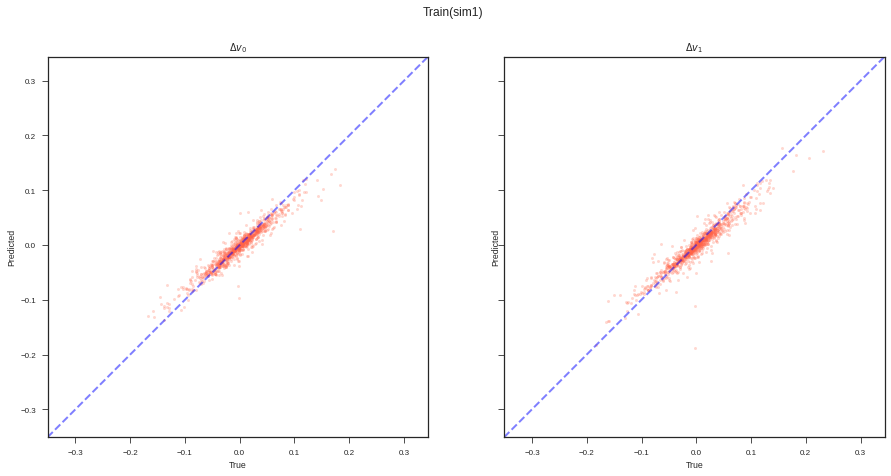

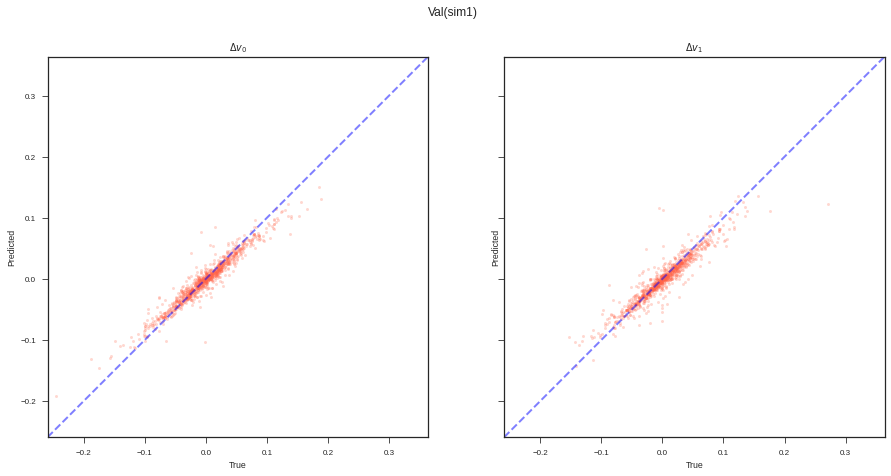

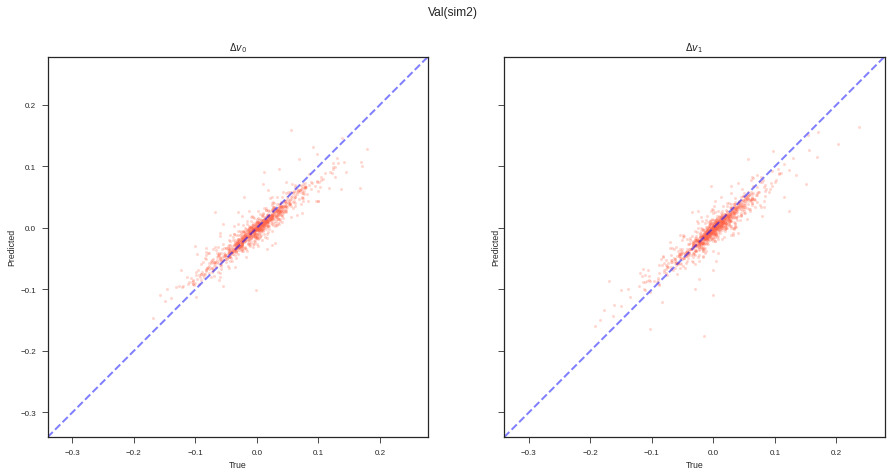

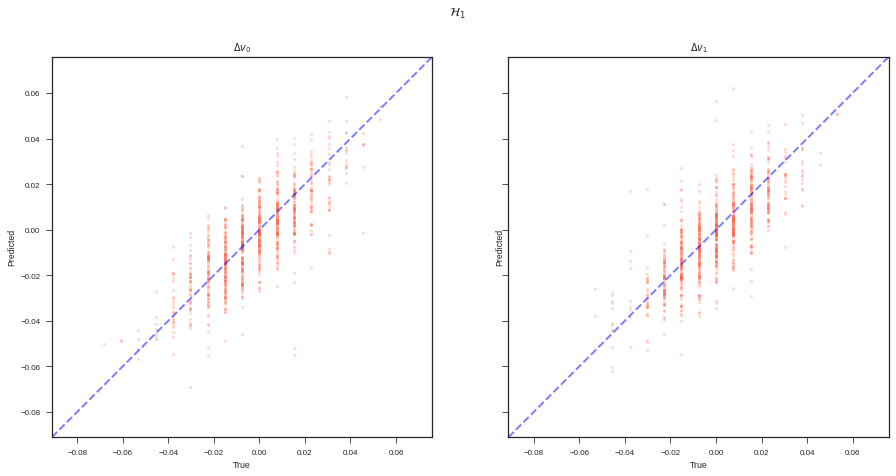

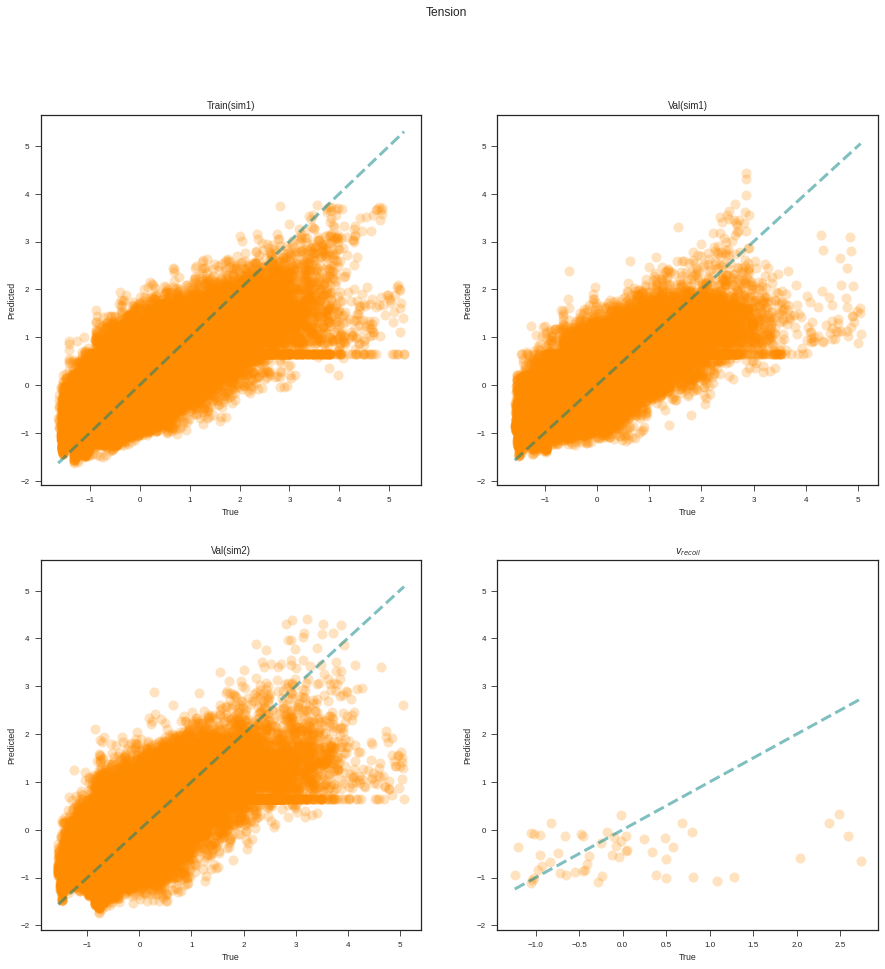

In [94]:
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'H1':   DataLoader(datasets_dict['H1'], batch_size=bs),
                                                  'A':   DataLoader(datasets_dict['A'], batch_size=bs)
                                                 },
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True,
                                                                   'val': True,
                                                                   'val2': True,
                                                                   'H1' : False,
                                                                   'A':True
                                                                  },
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2);

R,p=(0.22065723243649102, 0.1088497933541742)


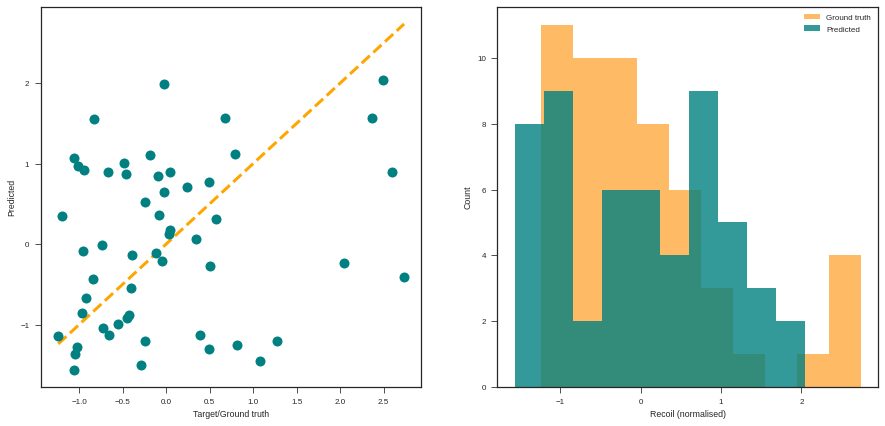

In [95]:
y_gt = torch.cat(tgt_out[1]['A'],axis=0).numpy()

y_pred = torch.cat(pred_out[1]['A'],axis=0).numpy()[~np.isnan(y_gt)]
y_pred_scaled = (y_pred- y_pred.mean())/y_pred.std()

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=[15,7])
axs = axs.ravel()
axs[0].plot([y_gt[~np.isnan(y_gt)].min(),y_gt[~np.isnan(y_gt)].max()],
            [y_gt[~np.isnan(y_gt)].min(),y_gt[~np.isnan(y_gt)].max()],'--',c='orange',lw=3)
axs[0].plot(y_gt[~np.isnan(y_gt)], y_pred_scaled, 'o',ms=10,c='teal')
# axs[0].axis('square')
axs[0].set_xlabel('Target/Ground truth')
axs[0].set_ylabel('Predicted')

axs[1].hist(y_gt,alpha=.6, color='darkorange', label='Ground truth');
axs[1].hist(y_pred_scaled,alpha=.8,color='teal',label='Predicted')
axs[1].set_xlabel('Recoil (normalised)')
axs[1].set_ylabel('Count')
axs[1].legend();

from scipy.stats import pearsonr
print(f'R,p={pearsonr(y_gt[~np.isnan(y_gt)], y_pred)}')

In [49]:
# # For log transfrom data
# y_gt = np.exp(torch.cat(tgt_out[1]['abln'],axis=0).numpy()*t_sd_log['abln'] + t_av_log['abln'])
# y_gt_scaled = (y_gt[~np.isnan(y_gt)] - y_gt[~np.isnan(y_gt)].mean())/y_gt[~np.isnan(y_gt)].std()

# y_pred = np.exp(torch.cat(pred_out[1]['abln'],axis=0).numpy()*t_sd_log['unimodal_wbasetens_sims'] + t_av_log['unimodal_wbasetens_sims'] )

# # gt_pred_ratio = y_gt[~np.isnan(y_gt)].max()/y_pred[~np.isnan(y_gt)].max()
# y_pred_scaled = (y_pred[~np.isnan(y_gt)] - y_pred[~np.isnan(y_gt)].mean())/y_pred[~np.isnan(y_gt)].std()

# fig,axs = plt.subplots(nrows=1,ncols=2,figsize=[15,7])
# axs = axs.ravel()
# axs[0].plot([y_gt_scaled.min(),y_gt_scaled.max()],
#             [y_gt_scaled.min(),y_gt_scaled.max()],'--',c='orange',lw=3)
# axs[0].plot(y_gt_scaled, y_pred_scaled, 'o',ms=10,c='teal')
# # axs[0].axis('square')
# axs[0].set_xlabel('Target/Ground truth')
# axs[0].set_ylabel('Predicted')

# axs[1].hist(y_gt_scaled,alpha=.6, color='darkorange', label='Ground truth');
# axs[1].hist(y_pred_scaled,alpha=.8,color='teal',label='Predicted')
# axs[1].set_xlabel('Recoil (normalised)')
# axs[1].set_ylabel('Count')
# axs[1].legend();

In [96]:
save_dir = './simgnn_data/saved_models/thesis/tension_MP_sim2sim'

write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

Model weights saved in 
./simgnn_data/saved_models/thesis/tension_MP_sim2sim/18042022_051501_SingleMP_Tension_h10_dp0.1bs2w5_net.pkl
